# Import Modules

In [1]:
import numpy as np
import pickle
import pandas as pd
import healpy as hp
import pysm3.units as u
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
from astropy.table import Table
import multiprocessing
from time import time
import utils 
import os
os.environ[
    "OMP_NUM_THREADS"
] = "64"
np.random.seed(10)

# Read Map

In [2]:
comp = "IQU"
mdir = "/global/project/projectdirs/cmb/data/planck2018/pr3/frequencymaps/"
m, h = hp.read_map(mdir + "HFI_SkyMap_353_2048_R3.01_full.fits",
                                       [c + "_STOKES" for c in comp], dtype = np.float64, h = True)
m <<= u.K_CMB
m = m.to('uK_RJ', equivalencies = u.cmb_equivalencies(353 * u.GHz))
I,Q,U = m
P = Q**2 + U**2
I = I**2

# Read Catalogue

In [3]:
target_url = 'https://irsa.ipac.caltech.edu/data/Planck/release_2/catalogs/HFI_PCCS_GCC_R2.02.fits'
PGCC = Table.read(target_url, format = 'fits')
df = PGCC.to_pandas()
df = df[df.FLUX_QUALITY == 1]    # Cut to best quality sources
df = df[df.FLUX_BLENDING == 0]   # Cut out overlapping sources
df = df.reset_index(drop = True) # Reset dataframe indices

# Cut out cold clump patches

Stack full catalogue in $I^2$ and $P^2$.

Select destination folder for pickled map-cutouts if you choose to save all patches

In [4]:
output_dir = "/global/cscratch1/sd/justinc/"

In [5]:
def stack_I(l, b, p):
    return(hp.gnomview(I, rot = [l,b,p],
                      reso = 1, xsize = 50,
                      coord = 'G', no_plot = True,
                      return_projected_map = True))
def stack_P(l, b, p):
    return(hp.gnomview(P, rot = [l,b,p],
                      reso = 1, xsize = 50,
                      coord = 'G', no_plot = True,
                      return_projected_map = True))

t0 = time()
glo = df['GLON']
gla = df['GLAT']
psi = np.random.randint(0,360,len(df))
num_proc = 16
pool = multiprocessing.Pool(processes = num_proc)

process_I = [pool.apply_async(stack_I,
                               args = (i, j, k)) for i, j, k in zip(glo, gla, psi)]
res_I = [p.get() for p in process_I]

process_P = [pool.apply_async(stack_P,
                               args = (i, j, k)) for i, j, k in zip(glo, gla, psi)]
res_P = [p.get() for p in process_P]
pool.close()
pool.join()
print(f'Stacking complete in in {(time()-t0)/60}m')
stack = [res_I, res_P]

###------ Uncomment this if you want to save all patches ------###
#with open(output_dir + "full_sample_patches.pkl", 'wb') as f:
#    pickle.dump(stack, f)

Stacking complete in in 12.437704519430797m


# Stack and observe results

In [7]:
stacked_sample = utils.sumstack(stack.copy())
background_corrected_sample = utils.BkgSubtract(stacked_sample.copy(), 18, 6)[0]

Polarisation_Fraction = (background_corrected_sample[1]/background_corrected_sample[0])[25][25]

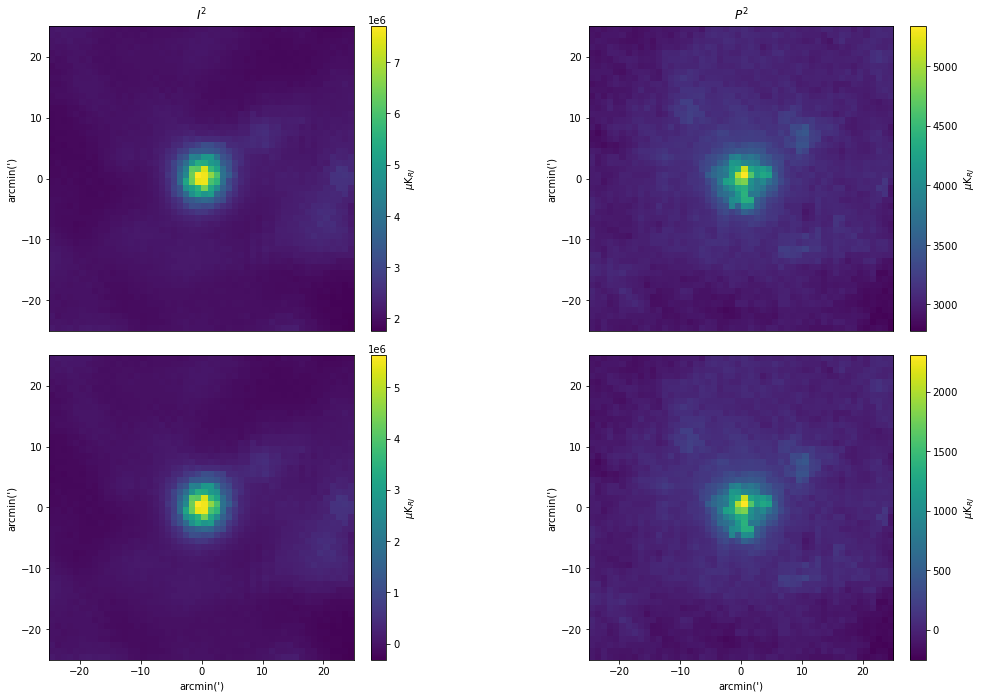

In [8]:
plt.rcParams.update({'font.size': 24})
fig, axs = plt.subplots(2,2,figsize=(10,10),)
fig.subplots_adjust(left = 0.02, bottom = 0.06, right = 1.45, top = 0.94, wspace = 0.1, hspace = 0.08)
ims = [utils.sumstack(stack.copy())[0], utils.sumstack(stack.copy())[1], background_corrected_sample[0], background_corrected_sample[1]]
for i in range(len(axs.ravel())):
    im = axs.ravel()[i].imshow(ims[i], extent=[-ims[i].shape[1]/2., ims[i].shape[1]/2., -ims[i].shape[0]/2., ims[i].shape[0]/2. ])
    if i == 1 or i == 3:   
        fig.colorbar(im, ax=axs.ravel()[i],fraction=0.046*(ims[i].shape[0]/ims[i].shape[1]), 
                     pad=0.035, label = "$\mu$K$_{RJ}$")
    else:
        fig.colorbar(im, ax=axs.ravel()[i],fraction=0.046*(ims[i].shape[0]/ims[i].shape[1]), 
                     pad=0.035, label = "$\mu$K$_{RJ}$")
        
axs[0][0].axes.get_xaxis().set_visible(False)
axs[0][1].axes.get_xaxis().set_visible(False)
axs[0][0].set_title(r'$I^2$')
axs[0][1].set_title(r'$P^2$')
axs[1][1].set_xlabel("arcmin(')")
axs[1][0].set_xlabel("arcmin(')")
axs[0][0].set_ylabel("arcmin(')")
axs[1][0].set_ylabel("arcmin(')")
axs[1][1].set_ylabel("arcmin(')")
axs[0][1].set_ylabel("arcmin(')")
plt.savefig('IPcutouts_filtered_new.pdf',bbox_inches='tight')

# Bootstrap Stack for Error Calculation

In [10]:
t0 = time()
filtered_bootstraps = utils.bootstrap_stack(sample = stack.copy(), 
                                     sample_size = 2500,
                                     Bkg_Sub = True)
print(f'Bootstrap 2500 samples in {(time()-t0)/60}m')

Bootstrap 2500 samples in 17.97191755771637m


In [11]:
bootstrap_outputs = utils.bootstraps2error(filtered_bootstraps)
full_sample_squared_results = utils.final_results(bootstrap_outputs)
full_sample_sqrt_results = utils.sqrt_res(full_sample_squared_results)

In [12]:
print(full_sample_squared_results)
print(full_sample_sqrt_results)

(0.00032918704286961074, 0.0002486236503096273, 2.1456297862318804e-05)
(0.018143512418206425, 0.006851585420145592, 0.0005912939393363577)


# Break sample into flux density bins

In [13]:
bin1 = df['FLUX_353_CLUMP'][df['FLUX_353_CLUMP'].between(0,2.5)].index.tolist()
bin2 = df['FLUX_353_CLUMP'][df['FLUX_353_CLUMP'].between(2.5,5)].index.tolist()
bin3 = df['FLUX_353_CLUMP'][df['FLUX_353_CLUMP'].between(5,7.5)].index.tolist()
bin4 = df['FLUX_353_CLUMP'][df['FLUX_353_CLUMP'].between(7.5,15)].index.tolist()
bin5 = df['FLUX_353_CLUMP'][df['FLUX_353_CLUMP'].between(15,25)].index.tolist()
bin6 = df['FLUX_353_CLUMP'][df['FLUX_353_CLUMP'].between(25,50)].index.tolist()
bin7 = df['FLUX_353_CLUMP'][df['FLUX_353_CLUMP'].between(50,320)].index.tolist()
df_b1 = df.loc[df.index[bin1]]
df_b2 = df.loc[df.index[bin2]]
df_b3 = df.loc[df.index[bin3]]
df_b4 = df.loc[df.index[bin4]]
df_b5 = df.loc[df.index[bin5]]
df_b6 = df.loc[df.index[bin6]]
df_b7 = df.loc[df.index[bin7]]

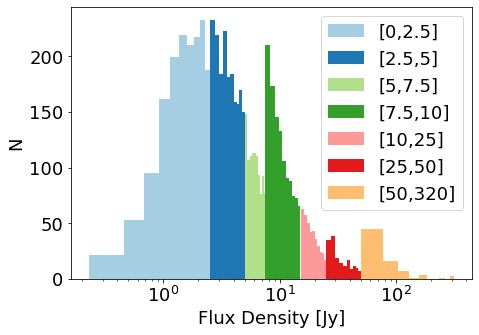

In [14]:
colours_bw = plt.cm.Paired(np.linspace(0,1,12))
CB_color_cycle = ['#E69F00', '#56B4E9', '#009E73',
                  '#F0E442', '#0072B2', '#D55E00',
                  '#CC79A7']

plt.rcParams.update({'font.size': 18})
flux_bins = [df_b1, df_b2, df_b3, df_b4, df_b5, df_b6, df_b7]
fbin_labels = [r'$0.0<S<2.5$', r'$2.5<S<5.0$', r'$5.0<S<7.5$', 
               r'$7.5<S<10$', r'$10<S<25$', r'$25<S<50$',
               r'$50<S<320$']
fbin_labels2 = [
    "[0,2.5]", 
    "[2.5,5]", 
    "[5,7.5]", 
    "[7.5,10]", 
    "[10,25]", 
    "[25,50]", 
    "[50,320]"
]
plt.figure(figsize = (7,5))
for i in range(len(flux_bins)):
    plt.hist(flux_bins[i]['FLUX_353_CLUMP'], bins = 10, label = f'{fbin_labels2[i]}',
            color = colours_bw[i], histtype = 'stepfilled')
plt.legend()
#plt.xlim(0,350)
plt.xscale('log')
plt.xlabel('Flux Density [Jy]')
plt.ylabel('N')
plt.tight_layout()
plt.savefig('fluxbins.pdf')
plt.show()

In [15]:
binned_stacks = []
psi = np.random.randint(0,360,len(df))
for df_bin in flux_bins:
    t0 = time()
    glo = df_bin['GLON']
    gla = df_bin['GLAT']
    num_proc = 16
    pool = multiprocessing.Pool(processes = num_proc)
    process_I = [pool.apply_async(stack_I,
                                   args = (i, j, k)) for i, j, k in zip(glo, gla, psi)]
    res_I = [p.get() for p in process_I]

    process_P = [pool.apply_async(stack_P,
                                   args = (i, j, k)) for i, j, k in zip(glo, gla, psi)]
    res_P = [p.get() for p in process_P]
    pool.close()
    pool.join()
    print("Stacking complete in:", time()-t0)
    stack = [res_I, res_P]
    binned_stacks.append(stack)

###------ Uncomment this if you want to save all patches ------###
#with open("/global/cscratch1/sd/justinc/flux_binned_stacks.pkl", 'wb') as f:
#    pickle.dump(binned_stacks, f)

Stacking complete in: 171.51695728302002
Stacking complete in: 200.53223633766174
Stacking complete in: 115.32406377792358
Stacking complete in: 134.1229603290558
Stacking complete in: 43.975568771362305
Stacking complete in: 23.782537698745728
Stacking complete in: 11.813312768936157


In [17]:
binned_bootstraps = []
binned_bootstraps_control = []
for i in binned_stacks:
    t0 = time()
    filtered_bootstraps = utils.bootstrap_stack(sample = i.copy(), 
                                     sample_size = 2500,
                                     Bkg_Sub = True)
    unfiltered_bootstraps = utils.bootstrap_stack(sample = i.copy(), 
                                     sample_size = 2500,
                                     Bkg_Sub = False)
    print(f'Bootstrap 2500 samples in {(time()-t0)/60}m')
    binned_bootstraps.append(filtered_bootstraps)
    binned_bootstraps_control.append(unfiltered_bootstraps)

Bootstrap 2500 samples in 4.500366282463074m
Bootstrap 2500 samples in 13.068323238690693m
Bootstrap 2500 samples in 3.487511396408081m
Bootstrap 2500 samples in 3.719190267721812m
Bootstrap 2500 samples in 1.0067808667818705m
Bootstrap 2500 samples in 0.4799983263015747m
Bootstrap 2500 samples in 0.26682146787643435m


In [18]:
binned_bootstrap_outputs = utils.bootstraps2error_bins(binned_bootstraps)
binned_bootstrap_control_outputs = utils.bootstraps2error_bins(binned_bootstraps_control)

In [19]:
full_sample_squared_results_binned = utils.final_results(binned_bootstrap_outputs)
mean_full_sample_squared_results_binned = utils.meanbinres(full_sample_squared_results_binned)
full_sample_sqrt_results_binned = utils.sqrt_res(full_sample_squared_results_binned)
mean_full_sample_sqrt_results_binned = utils.meanbinres(full_sample_sqrt_results_binned)

full_sample_squared_results_control_binned = utils.final_results(binned_bootstrap_control_outputs)
mean_full_sample_squared_results_control_binned = utils.meanbinres(full_sample_squared_results_control_binned)
full_sample_sqrt_results_control_binned = utils.sqrt_res(full_sample_squared_results_control_binned)
mean_full_sample_sqrt_results_control_binned = utils.meanbinres(full_sample_sqrt_results_control_binned)

/global/homes/j/justinc/.conda/envs/jc_env/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  del sys.path[0]
/global/homes/j/justinc/.conda/envs/jc_env/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.


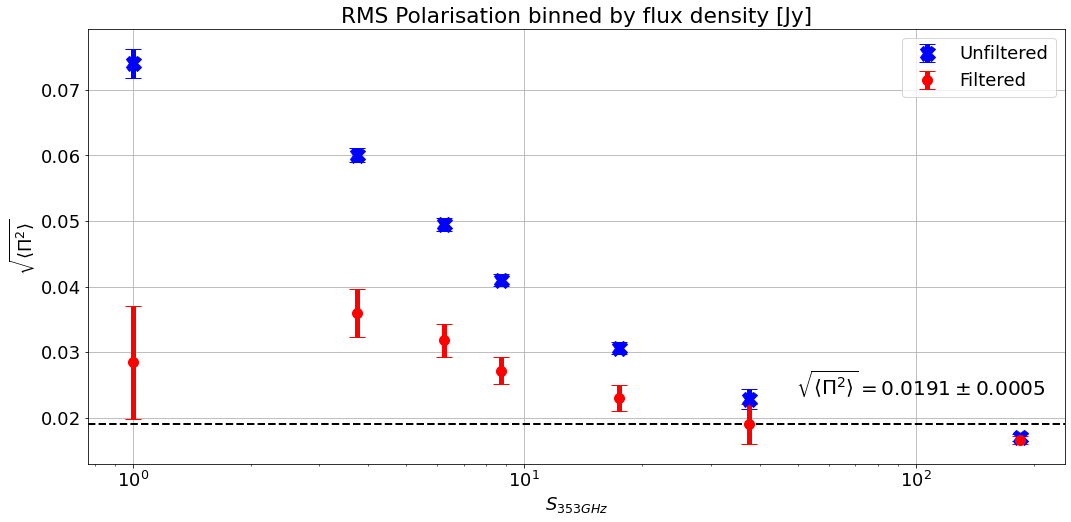

In [20]:
fig, ax = plt.subplots(figsize = (17.5,8))
x = [1,3.75,6.25,8.75,17.5,37.5,185]
binwidths  = [[0.0, 2.5], [2.5, 5], [5.0, 7.5], [7.5, 10], [10, 25], [25, 50], [50, 320]]

plt.errorbar(x, 
             full_sample_sqrt_results_control_binned[0], 
             yerr = full_sample_sqrt_results_control_binned[2], 
             fmt = 'o', 
             color = 'blue', 
             marker = 'X', 
             markersize = 15,
             capsize = 8, 
             fillstyle='full', lw = 5, label = 'Unfiltered')
plt.errorbar(x, 
             full_sample_sqrt_results_binned[0], 
             yerr = full_sample_sqrt_results_binned[2], 
             fmt = 'o', 
             color = 'red', 
             marker = 'o', 
             markersize = 10,
             capsize = 8, 
             fillstyle='full', lw = 5, label = 'Filtered')

plt.axhline(mean_full_sample_sqrt_results_binned[1][0], lw = 2, ls = '--', color = 'k')

ax.text(0.725, 0.15, r'$\sqrt{\langle\Pi^2\rangle} = %.4f \pm %.4f$' % (mean_full_sample_sqrt_results_binned[1][0], mean_full_sample_sqrt_results_binned[1][1]), ha='left', va='bottom', transform=ax.transAxes, fontsize = 20)
plt.ylabel(r'$\sqrt{\langle\Pi^2\rangle}$')
plt.xlabel('$S_{353 GHz}$')
plt.xscale('log')
plt.title(r'RMS Polarisation binned by flux density [Jy]')
plt.grid()
plt.legend()
plt.savefig('binned_flux_density_new.pdf')
plt.show()